# Liesel-GAM Demo Notebook

## Setup and Imports

In [4]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [5]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

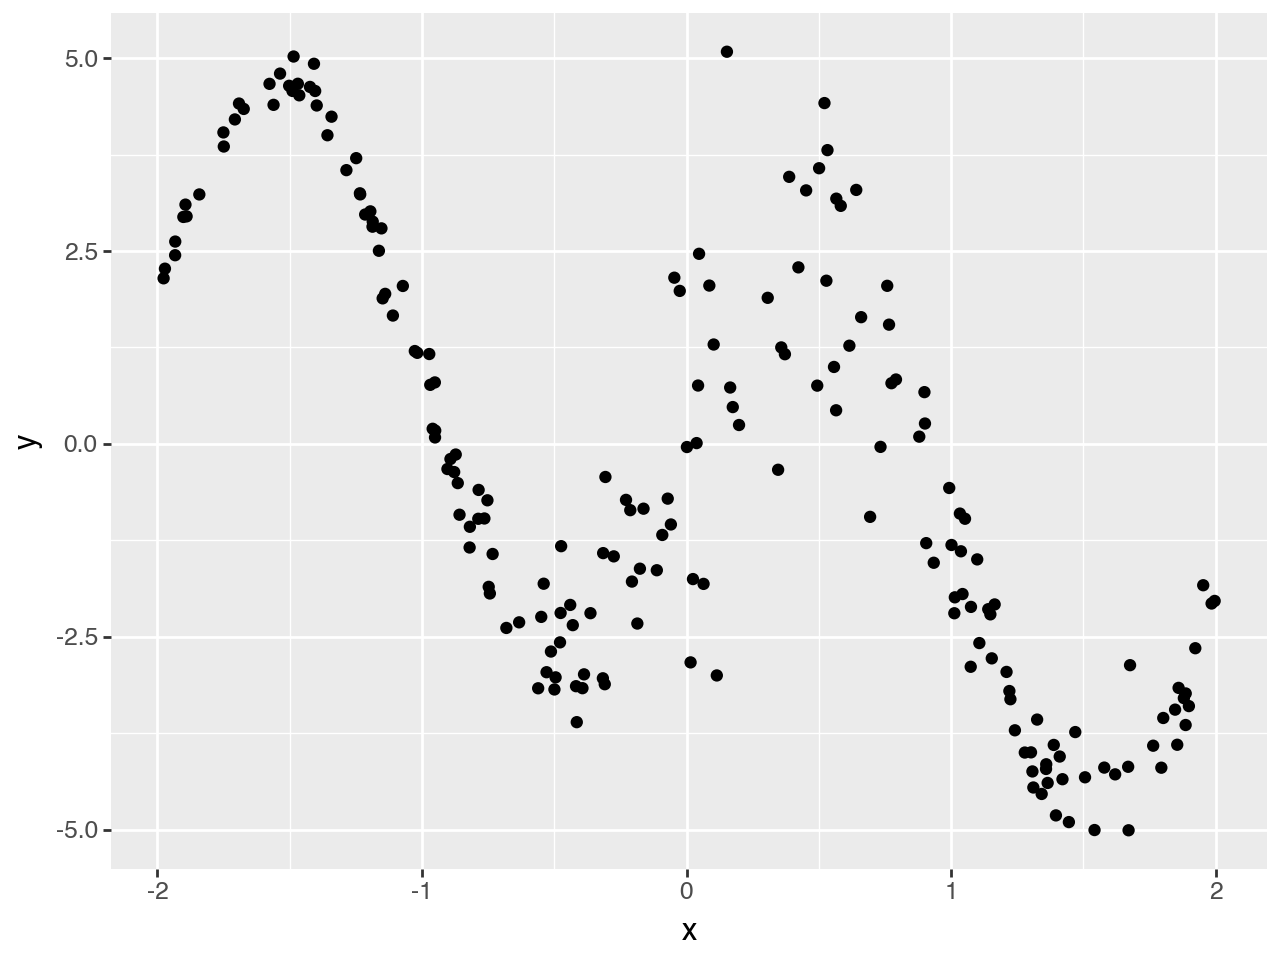

In [6]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [7]:
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [8]:
loc += tb.s("x", bs="tp")
scale += tb.s("x", bs="tp")

### Build and plot model

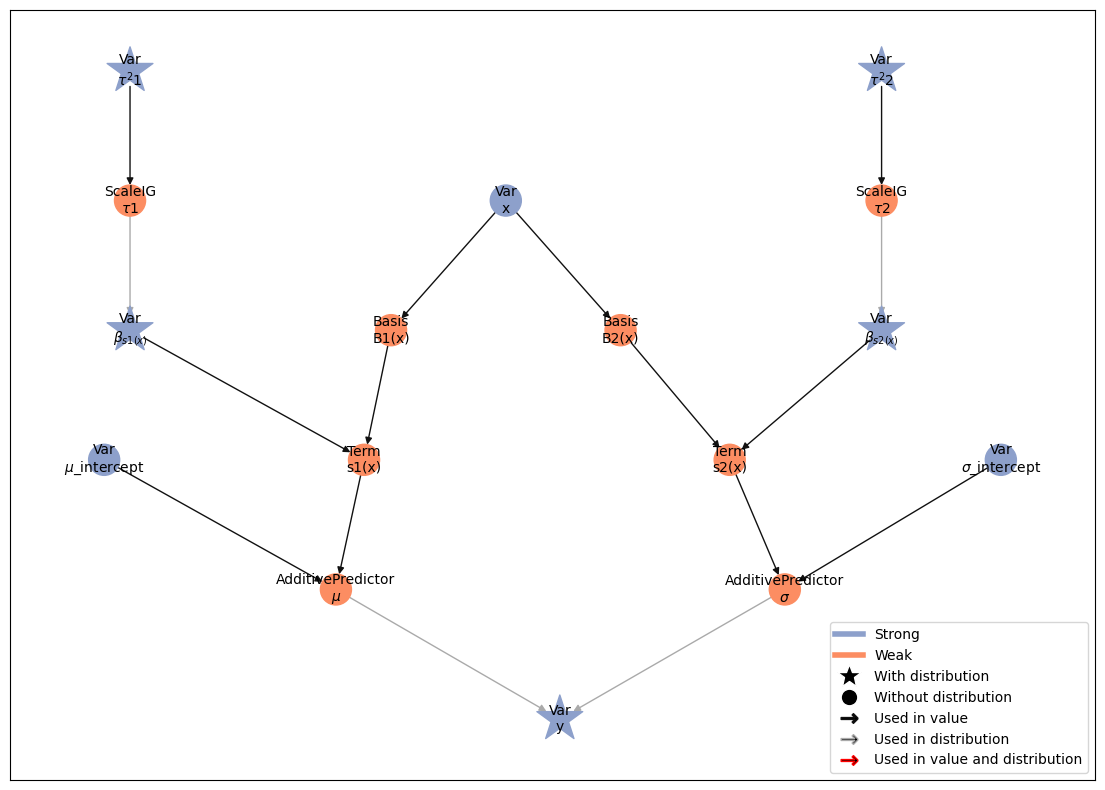

In [9]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [10]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\beta_{s2(x)}$', '$\\tau^2$2', '$\\mu$_intercept', '$\\beta_{s1(x)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.92chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1267.54chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 1, 0, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|███████████████████████████████

### MCMC summary

In [11]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel        mean          sd      q_0.05  \
parameter          index                                                  
$\beta_{s1(x)}$    (0,)   kernel_04   -6.765389    4.364732  -14.011139   
                   (1,)   kernel_04   -9.523000    3.964966  -16.075805   
                   (2,)   kernel_04   -2.234124    5.399643  -11.107186   
                   (3,)   kernel_04  -45.627464    2.946225  -49.531039   
                   (4,)   kernel_04  -43.183819    2.892153  -47.126928   
                   (5,)   kernel_04    0.702619    0.928371   -0.807759   
                   (6,)   kernel_04    4.340079    0.671757    3.257512   
                   (7,)   kernel_04   -1.152292    1.262690   -3.255070   
                   (8,)   kernel_04   45.409199    3.544658   40.841788   
$\beta_{s2(x)}$    (0,)   kernel_01    0.466786    2.744415   -3.652107   
                   (1,)   kernel_01    1.193725    2.558972   -2.500611   
                   (2,)   kernel_01    0.728797    2.508871   -3.185534   
                   (3,)   kernel_01   -4.373306    1.972459   -7.722635   
                   (4,)   kernel_01   -0.896744    1.763345   -3.880750   
                   (5,)   kernel_01    4.827430    0.869627    3.459584   
                   (6,)   kernel_01    0.408238    0.863587   -0.941409   
                   (7,)   kernel_01    0.689668    1.404365   -1.563299   
                   (8,)   kernel_01    4.199489    3.491005   -1.208946   
$\mu$_intercept    ()     kernel_03   -0.320718    0.065581   -0.417399   
$\sigma$_intercept ()     kernel_00   -0.619198    0.068744   -0.706591   
$\tau^2$1          ()     kernel_05  522.055725  309.010254  229.048880   
$\tau^2$2          ()     kernel_02    9.719498    9.021058    2.535153   

                               q_0.5       q_0.95  sample_size     ess_bulk  \
parameter          index                                                      
$\beta_{s1(x)}$    (0,)    -6.780048     0.458843         4000  3413.935481   
                   (1,)    -9.534188    -3.094425         4000  2974.284412   
                   (2,)    -2.239062     6.986354         4000  3929.569464   
                   (3,)   -45.671740   -41.835016         4000  1906.722789   
                   (4,)   -43.256666   -39.316536         4000  3208.599709   
                   (5,)     0.691622     2.242268         4000  1335.273394   
                   (6,)     4.351433     5.421240         4000  3127.837999   
                   (7,)    -1.159943     0.854948         4000  3626.666662   
                   (8,)    45.531975    50.061095         4000  3303.514455   
$\beta_{s2(x)}$    (0,)     0.353598     5.105660         4000  2524.027496   
                   (1,)     1.158132     5.273828         4000  2321.531393   
                   (2,)     0.615270     4.946615         4000  2528.567425   
                   (3,)    -4.278702    -1.308361         4000  1580.764212   
                   (4,)    -0.858594     1.872458         4000  2353.003462   
                   (5,)     4.808625     6.270445         4000  1916.759670   
                   (6,)     0.396339     1.802868         4000  2149.541123   
                   (7,)     0.656997     3.046638         4000  2146.905769   
                   (8,)     4.072359     9.748302         4000  2246.032307   
$\mu$_intercept    ()      -0.320550    -0.222095         4000   931.386858   
$\sigma$_intercept ()      -0.621156    -0.532598         4000  2899.175304   
$\tau^2$1          ()     445.561844  1064.021979         4000  4055.351340   
$\tau^2$2          ()       7.519231    22.679224         4000  1970.096529   

                             ess_tail      rhat  
parameter          index                         
$\beta_{s1(x)}$    (0,)   3798.499715  1.000144  
                   (1,)   2921.254525  1.000805  
                   (2,)   3812.964143  1.000677  
                   (3,)   2852.7

### MCMC trace plots

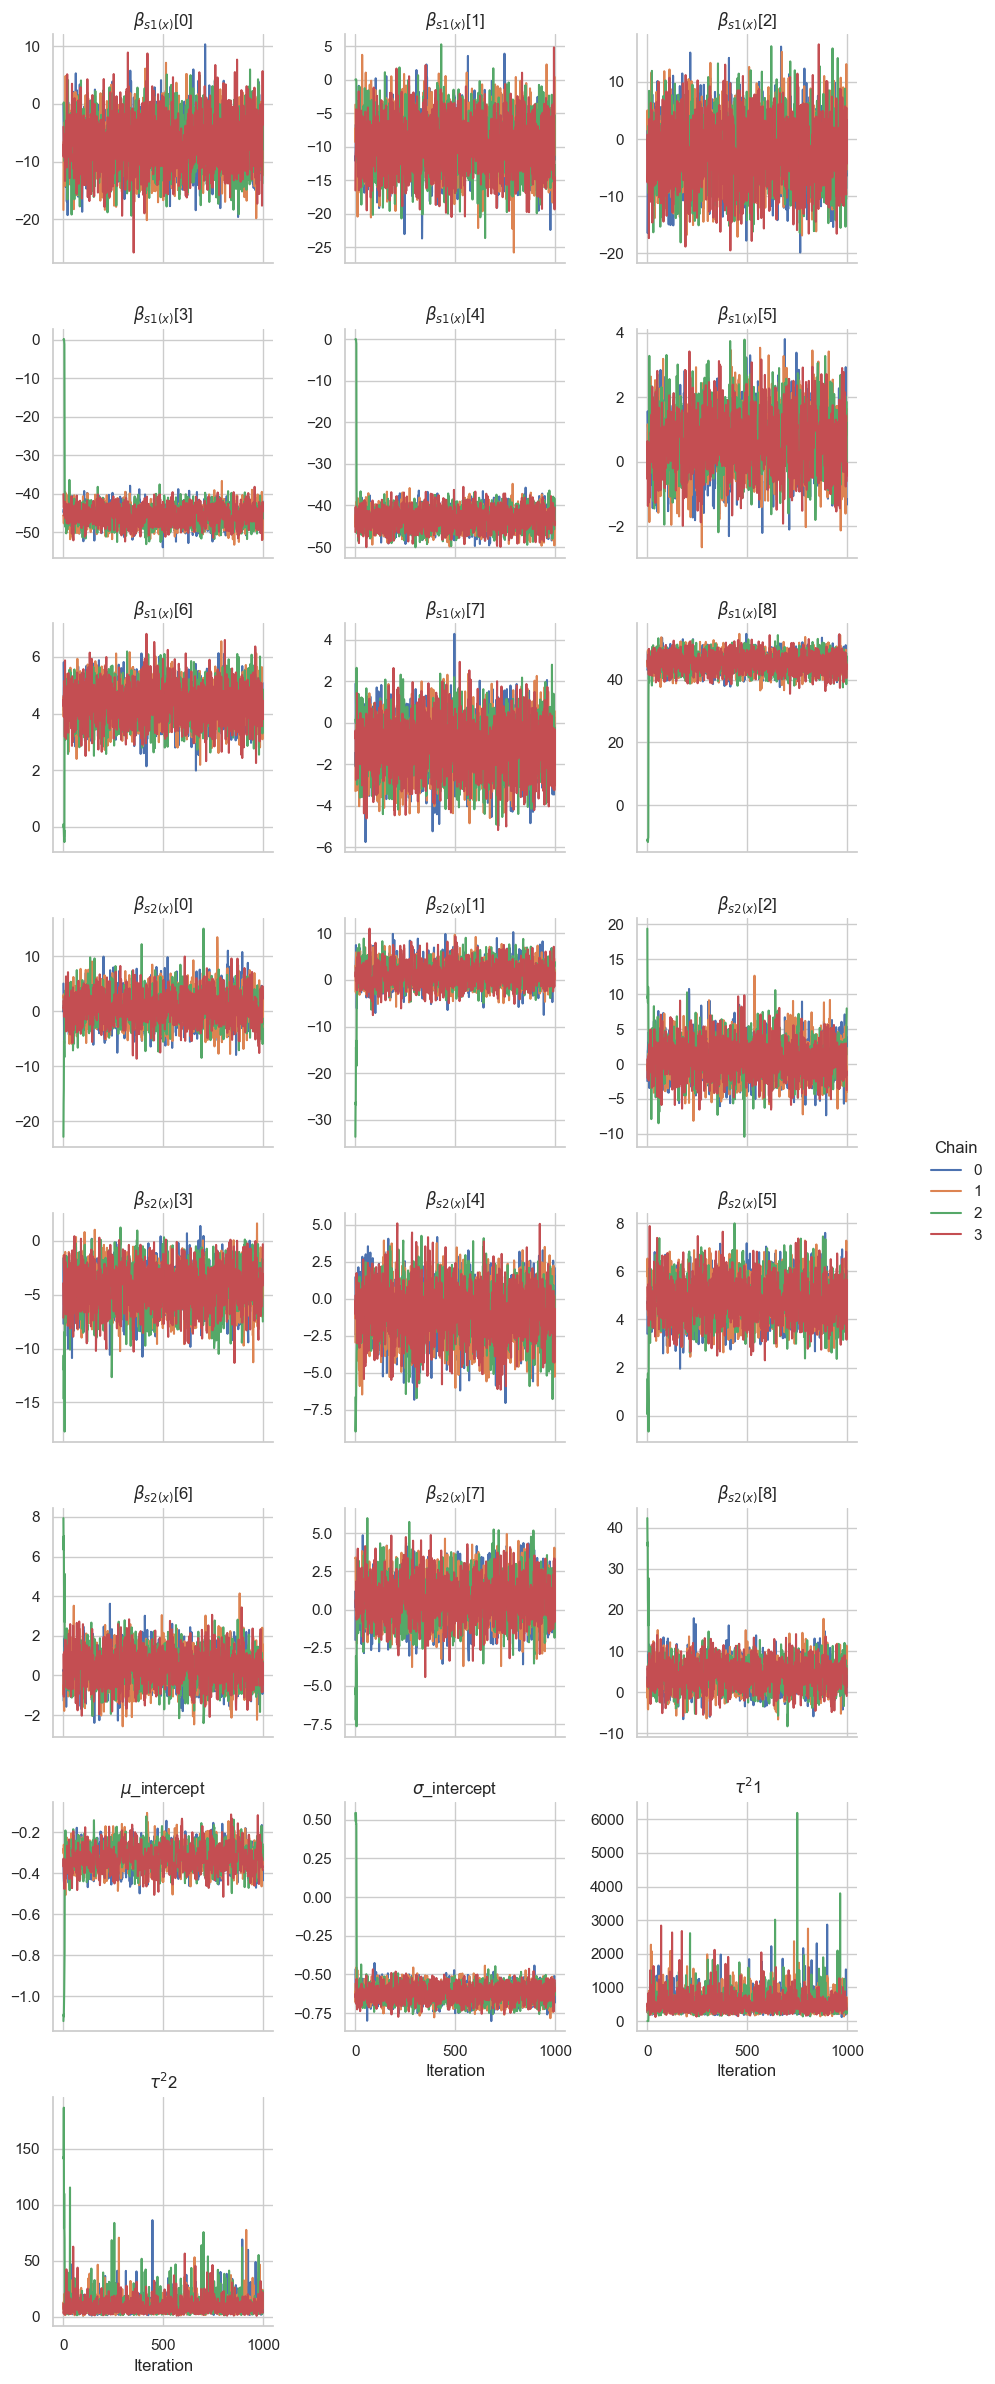

In [12]:
gs.plot_trace(results)

## Predictions

In [13]:
samples = results.get_posterior_samples()

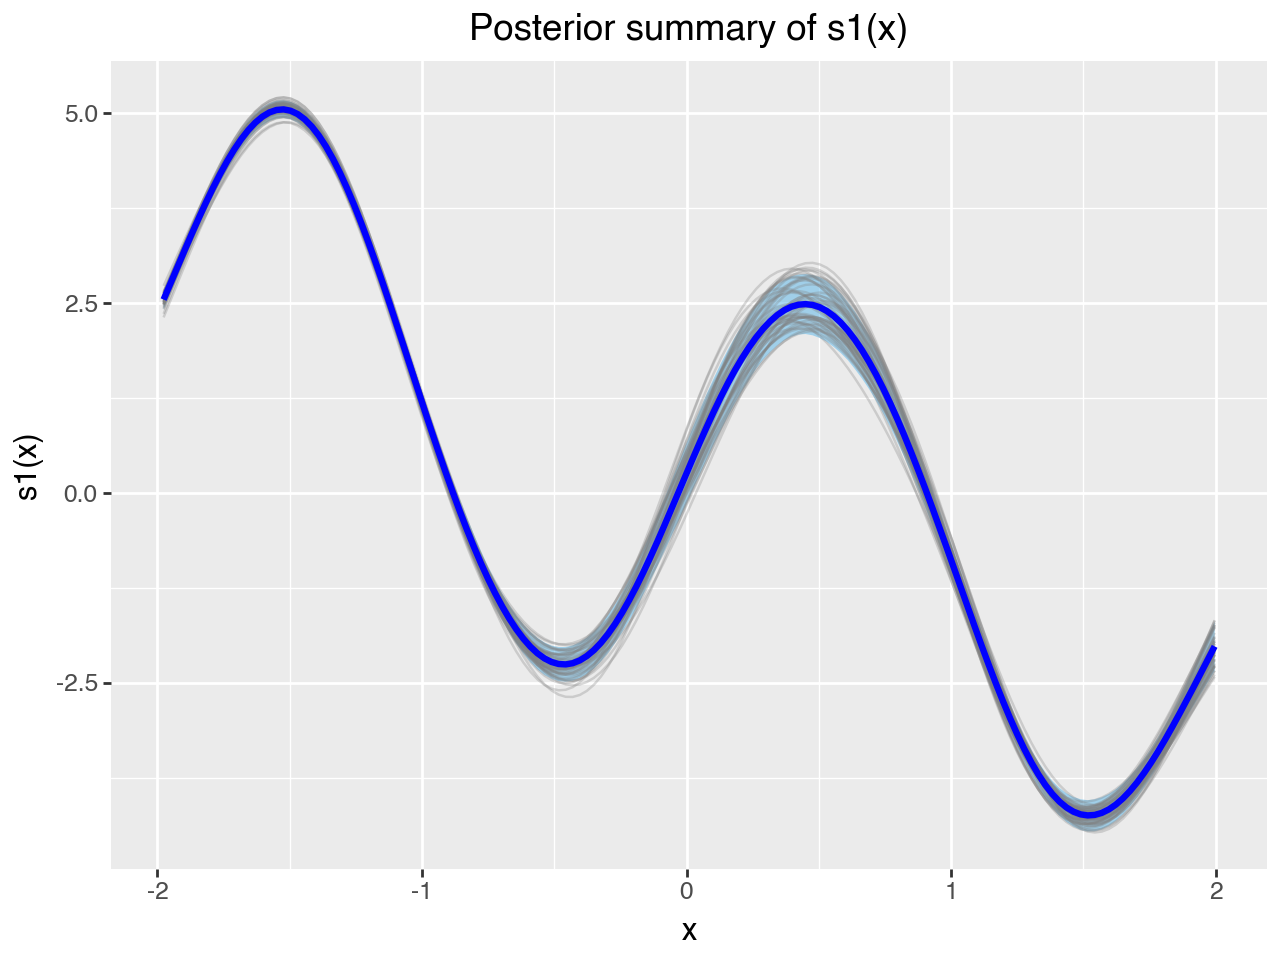

In [15]:
gam.plot_1d_smooth(term=model.vars["s1(x)"], samples=samples)

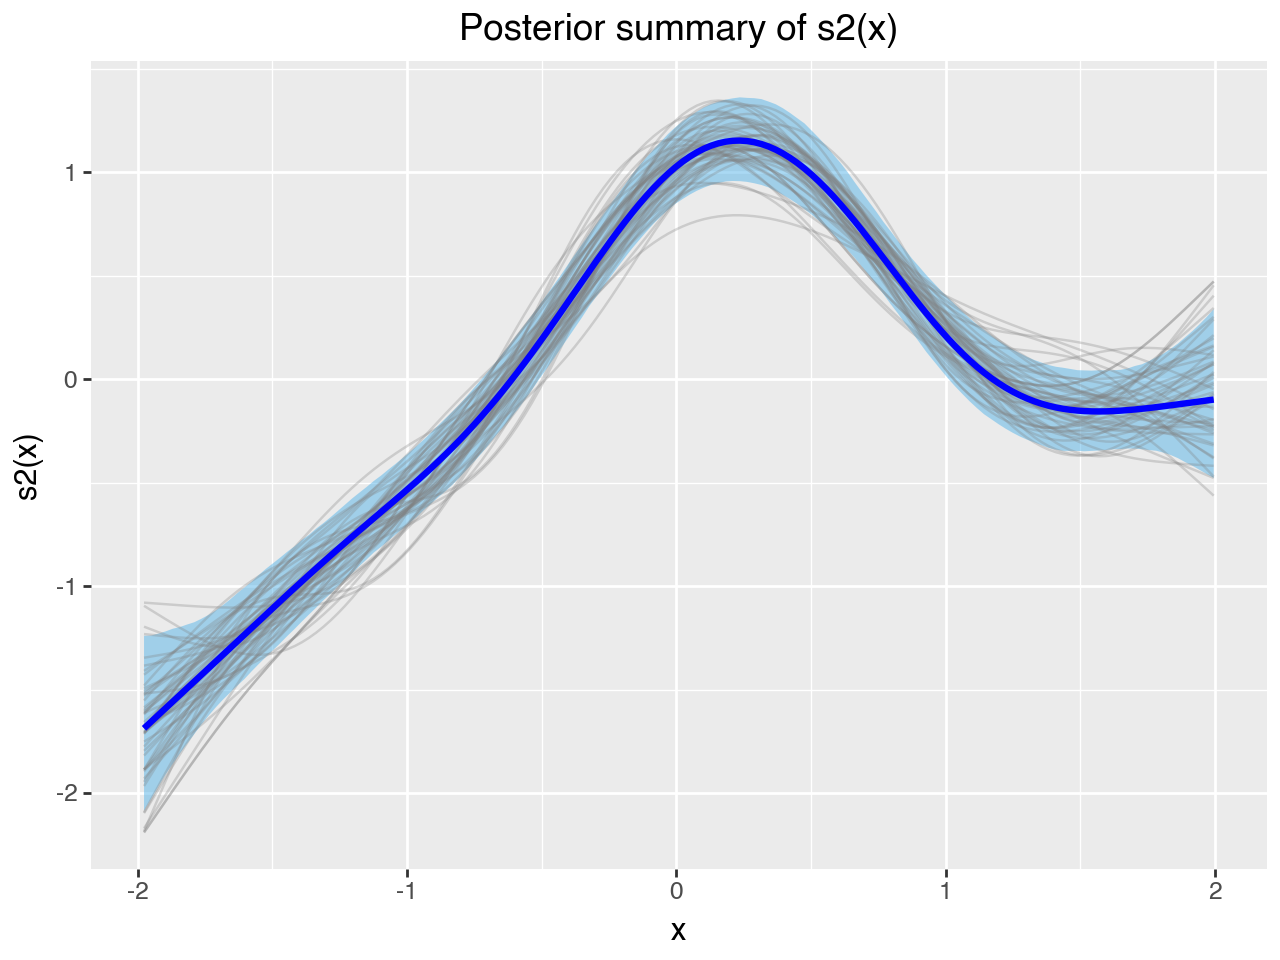

In [16]:
gam.plot_1d_smooth(term=model.vars["s2(x)"], samples=samples)